# Performance di detection e counting

In questo notebook analizzeremo le performance di detection del modello guardando a **F1 score**, **precision** e **recall** come metriche.

Le prestazioni in termine di conteggio saranno analizzate invece dal punto di vista dello **scarto assoluto medio (MAE), mediano (MedAE) e scarto percentuale (MPE)** tra i conteggi reali e quelli predetti dal modello.

Il codice è molto simile a quanto presentato in questo modulo, tuttavia aggiungeremo delle implementazioni di routine per calcolare queste metriche in una maniera adeguata per il nostro problema.

Inoltre, applicheremo un **thresholding con soglia a 0.9** e **post-processing** come descritto nel nostebook *03.05 - Valutazione - Ispezione visiva.ipynb*. 

<div class="alert alert-block alert-info">

Di seguito utilizzeremo solo il **modello costruito con la DiceLoss**, tuttavia il codice è facilmente riusabile per gli altri modelli. L'unica cosa da cambiare è la cartella dove pescare il modelle pre-allenato.
</div>

In [1]:
import sys
from fastai.vision.all import *

sys.path.insert(0, str(Path.cwd().parent))

from utils import write_config, load_config


# data and augmentation params
BS = 1
RESIZE = 224

# model params
N_IN, N_OUT = 16, 2

# optimizer params
LOSS_FUNC, LOSS_NAME = DiceLoss(axis=1, smooth=1e-06, reduction='mean', square_in_union=False), 'Dice'

EXP_NAME = "Dice"
log_path = Path().cwd().parent / 'logs' / EXP_NAME  
model_path = log_path.parent.parent / f'models/{EXP_NAME}'

## Dataloader

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-b

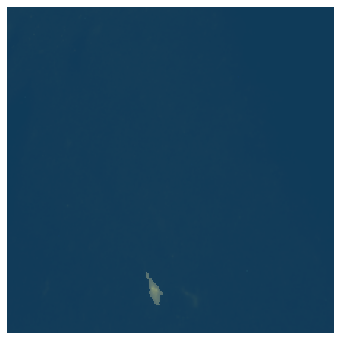

In [2]:
data_path = Path('../fluocells_data/all_images')

# read train/valid/test split dataframe
split_df = pd.read_csv(data_path.parent / 'split_df.csv')
trainval_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='train' or split=='valid'").filename]

def label_func(p):
    return Path(str(p).replace('images', 'masks'))

def is_valid(p):
    return split_df.loc[split_df.filename == p.name, 'split'].values[0] == 'valid'

# augmentation
tfms = [
    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
#     RandomCrop(CROP_SIZE),
    *aug_transforms(
        size=RESIZE, # resize
    )
]


# splitter
splitter = FuncSplitter(lambda p: is_valid(p))

# dataloader
dls = SegmentationDataLoaders.from_label_func(
    data_path, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    batch_tfms=tfms,
    device='cpu'
)

dls.show_batch(max_n=9, figsize=(6,6))

### Test dataloader

In questo caso siamo interessati a valutare le performance del modello fuori campione.

Per questo motivo aggiungeremo un dataloader che va a pescare direttamente le 28 immagini di test.

Numero immagini di test: 28


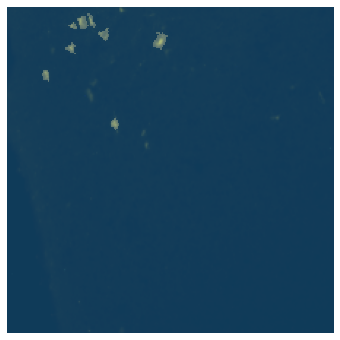

In [3]:
test_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='test'").filename]

print(f"Numero immagini di test: {len(test_fnames)}")
test_dl = dls.test_dl(test_fnames, with_labels=True)
test_dl.show_batch(figsize=(8,6))

## Learner

Anche in questo caso possiamo riutilizzare il codice sfruttato nel training.

Eviteremo tuttavia le callback e le metriche che al momento non ci interessano per l'ispezione visiva.

In [4]:
from blocks import cResUnet

model = cResUnet(N_IN, N_OUT)

learn = Learner(dls, model=model, loss_func=LOSS_FUNC,
                metrics=[Dice, foreground_acc],
                path=log_path , 
                model_dir=model_path,
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/PycharmProjects/c-resunet-DLI/logs/Dice
Model save path: /home/luca/PycharmProjects/c-resunet-DLI/models/Dice


cResUnet (Input shape: 1 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 1 x 224 x 224   
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     1 x 16 x 224 x 224  
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     1 x 16 x 112 x 112  
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                   

## Load model

Una volta definito l'oggetto `Learner`, il modello verrà inizializzato con pesi random come di consueto. 

Per sfruttare i pesi pre-allenati dovremo quindi ripescarli da dove li avevamo salvati con `SaveModelCallback`.

Per fare ciò basta sfruttare il metodo `.load(file)` che andrà a caricare i pesi salvati nel file con estensione *.pth*.

In [5]:
print(f"Loading pesi da: {model_path}")

learn.load(model_path / 'model') # model.pth

Loading pesi da: /home/luca/PycharmProjects/c-resunet-DLI/models/Dice


# Performance


Per misurare le performance di detection implementeremo alcune utils per personalizzare il calcolo delle metriche di interesse. In particolare

## Utils

In [6]:
from math import hypot
from scipy import ndimage
from skimage.morphology import remove_small_objects

MIN_DIST = 8
def compute_metrics(pred_mask_binary, mask, metrics, img_name):
    # extract predicted objects and counts
    pred_label, pred_count = ndimage.label(pred_mask_binary)
    pred_objs = ndimage.find_objects(pred_label)

    # compute centers of predicted objects
    pred_centers = []
    for ob in pred_objs:
        pred_centers.append(((int((ob[0].stop - ob[0].start)/2)+ob[0].start),
                             (int((ob[1].stop - ob[1].start)/2)+ob[1].start)))

    # extract target objects and counts
    targ_label, targ_count = ndimage.label(mask)
    
    # remove small objects
    remove_small_objects(
        targ_label, min_size=10, connectivity=1, in_place=False)
    
    
    targ_objs = ndimage.find_objects(targ_label)

    # compute centers of target objects
    targ_center = []
    for ob in targ_objs:
        targ_center.append(((int((ob[0].stop - ob[0].start)/2)+ob[0].start),
                            (int((ob[1].stop - ob[1].start)/2)+ob[1].start)))

    # associate matching objects, true positives
    tp = 0
    fp = 0
    for pred_idx, pred_obj in enumerate(pred_objs):

        min_dist = MIN_DIST  # 1.5-cells distance is the maximum accepted (scale 224x224 px)
        TP_flag = 0

        for targ_idx, targ_obj in enumerate(targ_objs):

            dist = hypot(pred_centers[pred_idx][0]-targ_center[targ_idx][0],
                         pred_centers[pred_idx][1]-targ_center[targ_idx][1])

            if dist < min_dist:

                TP_flag = 1
                min_dist = dist
                index = targ_idx

        if TP_flag == 1:
            tp += 1
            TP_flag = 0

            targ_center.pop(index)
            targ_objs.pop(index)

    # derive false negatives and false positives
    fn = targ_count - tp
    fp = pred_count - tp

    # update metrics dataframe
    metrics.loc[img_name] = [tp, fp, fn, targ_count, pred_count]

    return(metrics)

## Valutazione test set

In [7]:
from tqdm.auto import tqdm
from utils import thresh_format, mask_post_processing, F1Score


def make_model_prediction(test_dl, t, debug=False):
    
    train_metrics = pd.DataFrame(
        columns=["TP", "FP", "FN", "Target_count", "Predicted_count"])
        
    for idx, b in tqdm(enumerate(test_dl), total=test_dl.n):
        img_name = test_dl.items[idx]

        img, mask = b
        with torch.no_grad():
            heatmap = learn.model(img)

        pred_mask = thresh_format(heatmap, t).squeeze().permute(1,2,0).argmax(dim=2).squeeze().type(torch.uint8) # .to('cpu')
        pred_mask = mask_post_processing(pred_mask)
        compute_metrics(pred_mask, mask.to(
            'cpu').squeeze(), train_metrics, img_name.name)

    summary = F1Score(train_metrics)
    output = [t, summary]

    if debug:
        output.append(train_metrics)

    return output

In [8]:
t = 0.9
res = pd.DataFrame.from_dict({}, orient='index',
                         columns=["F1", "MAE", "MedAE", "MPE", "accuracy", "precision", "recall"])
_, summary, metrics_df = make_model_prediction(test_dl, t, debug=True)
res.loc[t] = summary

  0%|          | 0/28 [00:00<?, ?it/s]

/home/luca/PycharmProjects/c-resunet-DLI/utils.py:57: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
/home/luca/PycharmProjects/c-resunet-DLI/utils.py:70: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),
<ipython-input-6-4688f3456a2a>:21: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  remove_small_objects(


### Detection

In [9]:
res[['F1', 'precision', 'recall']]

F1  precision    recall
0.9  0.724735   0.728829  0.720686

Il nostro approccio raggiunge un F1 score di ~0.72, mantenendo al contempo un buon bilanciamento tra precision e recall, i.e. tra falsi positivi e falsi negativi.

Malgrado questo sia già un discreto risultato per un'applicazione reale, possiamo provare a guardare il tipo di errori commessi dal modello per cercare di capirne meglio i punti deboli e prendere spunto per eventuali migliorie da apportare.

In [10]:
import cv2
import matplotlib.patches as mpatches


DRAW_OFFSET = 5
PATCH_RADIUS = 0.05
BOX_WIDTH = 1


def plot_predictions_with_metrics(img, img_name, pred_mask, mask, suptitle=True):
    '''Plot original image with bounding boxes for TP, FP, and FN.
    
    Keyword arguments:
    img -- array of the original image
    img_name -- name of the image to print
    pred_mask -- array of the predicted mask
    mask -- groundtruth mask
    
    Return: None.
    '''
    
    img_copy = img.copy()
    print(img_name)
    pred_mask = pred_mask.astype("bool")

    pred_label, pred_rgb = ndimage.label(pred_mask)
    pred_objs = ndimage.find_objects(pred_label)

    # read mask and extract target objects and counts
    true_label, true_count = ndimage.label(mask)

    # remove small objects from resizing
    true_label = remove_small_objects(
            true_label, min_size=10, connectivity=1, in_place=False)
    true_objs = [obj for obj in ndimage.find_objects(true_label) if obj]
    # true_objs = ndimage.find_objects(true_label)
    
    # compute centers of predicted objects
    pred_centers = []
    for ob in pred_objs:
        pred_centers.append(((int((ob[0].stop - ob[0].start) / 2) + ob[0].start),
                             (int((ob[1].stop - ob[1].start) / 2) + ob[1].start)))

    # compute centers of target objects
    targ_center = []
    for ob in true_objs:
        targ_center.append(((int((ob[0].stop - ob[0].start) / 2) + ob[0].start),
                            (int((ob[1].stop - ob[1].start) / 2) + ob[1].start)))

    # associate matching objects, true positives
    tp = 0
    tp_objs = []
    
    # graphic settings
    offset = DRAW_OFFSET
    box_width = BOX_WIDTH
    patch_r = PATCH_RADIUS


    for pred_idx, pred_obj in enumerate(pred_objs):

        min_dist = MIN_DIST  # 1.5-cells distance is the maximum accepted
        TP_flag = 0

        for targ_idx, targ_obj in enumerate(true_objs):

            dist = hypot(pred_centers[pred_idx][0] - targ_center[targ_idx][0],
                         pred_centers[pred_idx][1] - targ_center[targ_idx][1])

            if dist < min_dist:
                TP_flag = 1
                min_dist = dist
                index_targ = targ_idx
                index_pred = pred_idx

        if TP_flag == 1:
            tp += 1
            TP_flag = 0
            cv2.rectangle(img_copy, (pred_objs[index_pred][1].start - offset, pred_objs[index_pred][0].start - offset),
                          (pred_objs[index_pred][1].stop + offset, pred_objs[index_pred][0].stop + offset), (0, 255, 0), box_width)

            tp_objs.append(pred_objs[index_pred])
            targ_center.pop(index_targ)
            true_objs.pop(index_targ)

    # derive false negatives and false positives
    fp = 0
    for pred_obj in pred_objs:
        if pred_obj not in tp_objs:
            cv2.rectangle(img_copy, (pred_obj[1].start - offset, pred_obj[0].start - offset),
                          (pred_obj[1].stop + offset, pred_obj[0].stop + offset), (255, 0, 0), box_width)
            fp += 1

    fn = 0
    for targ_obj in true_objs:
        cv2.rectangle(img_copy, (targ_obj[1].start - offset, targ_obj[0].start - offset),
                      (targ_obj[1].stop + offset, targ_obj[0].stop + offset), (0, 0, 255), box_width)
        fn += 1

    ae = abs(true_count - pred_rgb)

    # plot
    legend_background_color = 'white'
    line_thickness = 1.5
    plt.figure(figsize=(12, 12))
    if suptitle:
        plt.suptitle(img_name)

    plt.imshow(img_copy, cmap=plt.cm.RdBu)
    tp_patch = mpatches.Circle((0.1, 0.1), patch_r, facecolor=legend_background_color,
                               edgecolor="green", linewidth=line_thickness)
    fp_patch = mpatches.Circle((0.1, 0.1), patch_r, facecolor=legend_background_color,
                               edgecolor="red", linewidth=line_thickness)
    fn_patch = mpatches.Circle((0.1, 0.1), patch_r, facecolor=legend_background_color,
                               edgecolor="blue", linewidth=line_thickness)
    ae_patch = mpatches.Circle((0.1, 0.1), 0, facecolor=legend_background_color,
                               edgecolor=legend_background_color, linewidth=line_thickness)
    plt.title("Predicted count: {} - True count: {} - Absolute Error: {}".format(pred_rgb, true_count, ae), fontsize=18)

    legend = plt.legend([tp_patch, fp_patch, fn_patch, ae_patch],
                        ["True Positive: {}".format(tp), "False Positive: {}".format(fp),
                         "False Negative: {}".format(fn), 
#                          "Absolute Error: {}".format(ae)
                        ],
                        bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=4, fontsize=18)
    frame = legend.get_frame()
    frame.set_color(legend_background_color)
    plt.show()
    return (None)

  0%|          | 0/28 [00:00<?, ?it/s]

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/luca/PycharmProjects/c-resunet-DLI/utils.py:57: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
/home/luca/PycharmProjects/c-resunet-DLI/utils.py:70: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  l

Mar19bS1C5R1_DMr_200x_y.png


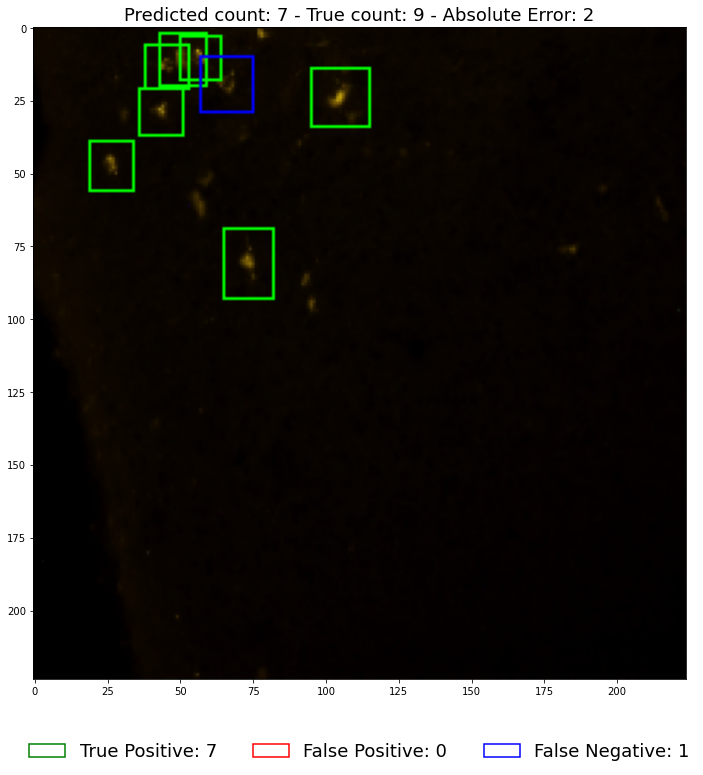

Mar26bS1C4R2_DMr_200x_y.png


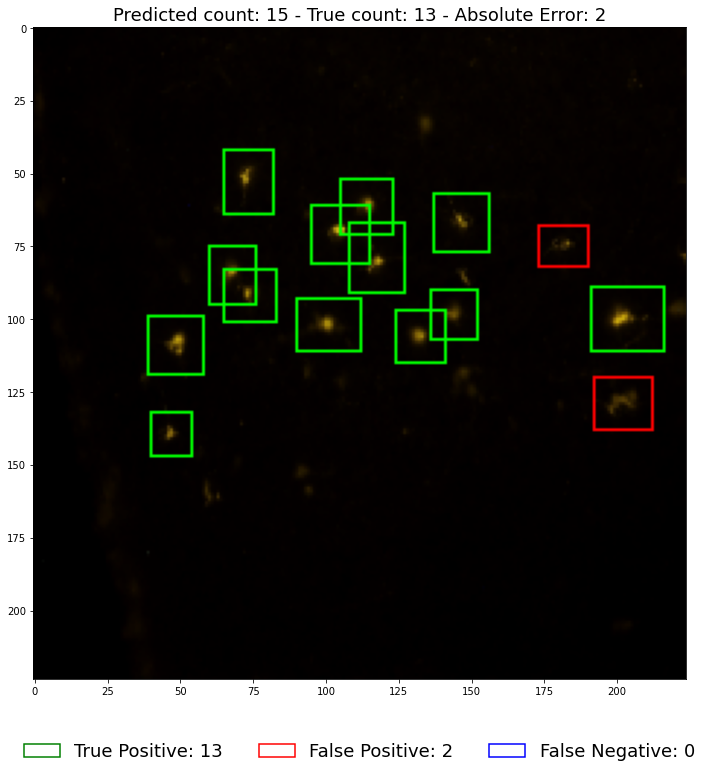

Mar24bS1C2R3_DMr_200x_y.png


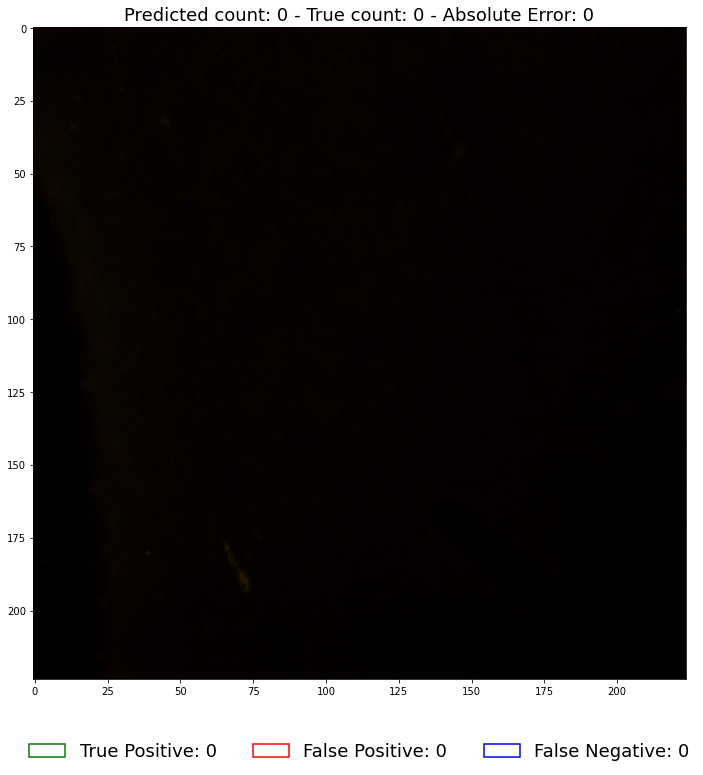

Mar24bS1C3R1_LHl_200x_y.png


<ipython-input-10-3d6d8d693c11>:33: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  true_label = remove_small_objects(


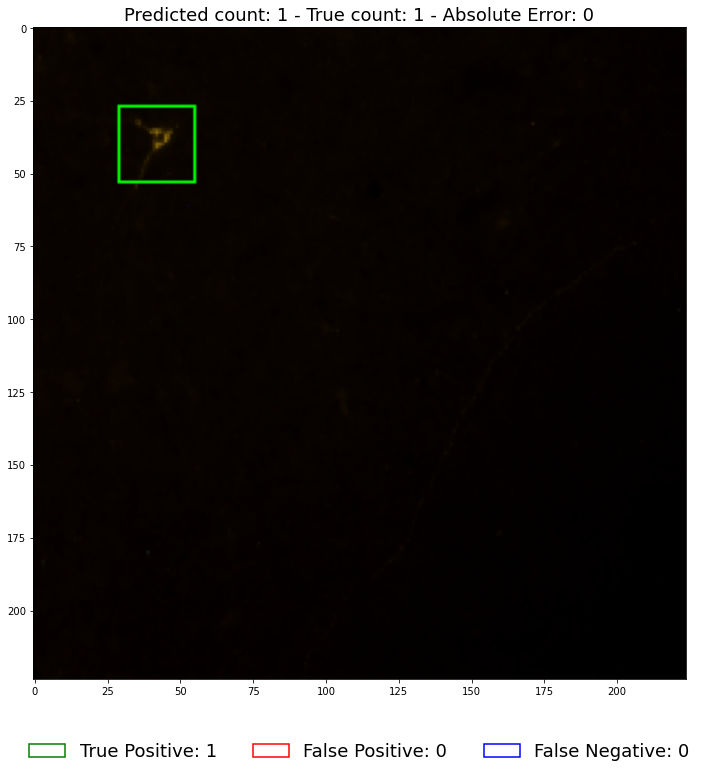

Mar27bS1C3R1_LHl_200x_y.png


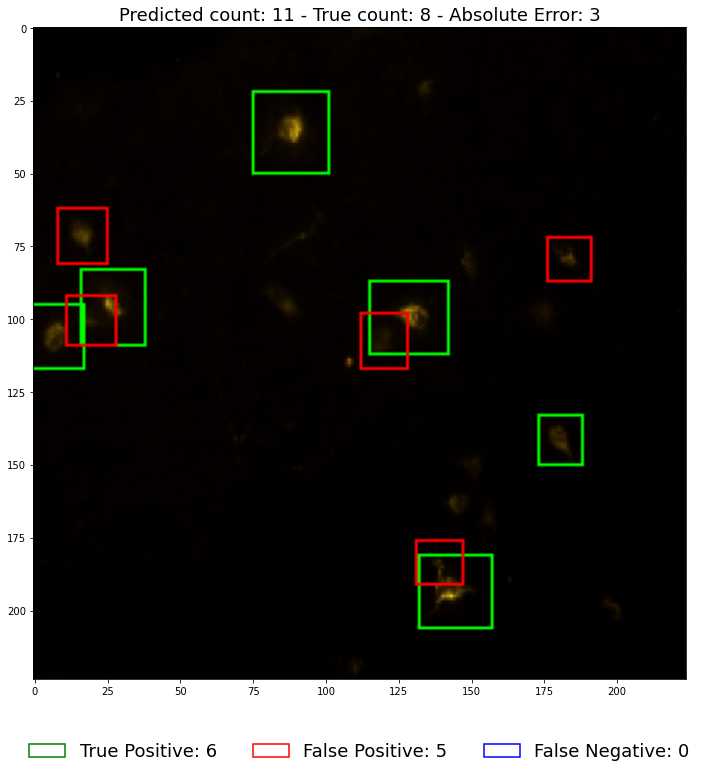

Mar23bS1C6R3_LHl_200x_y.png


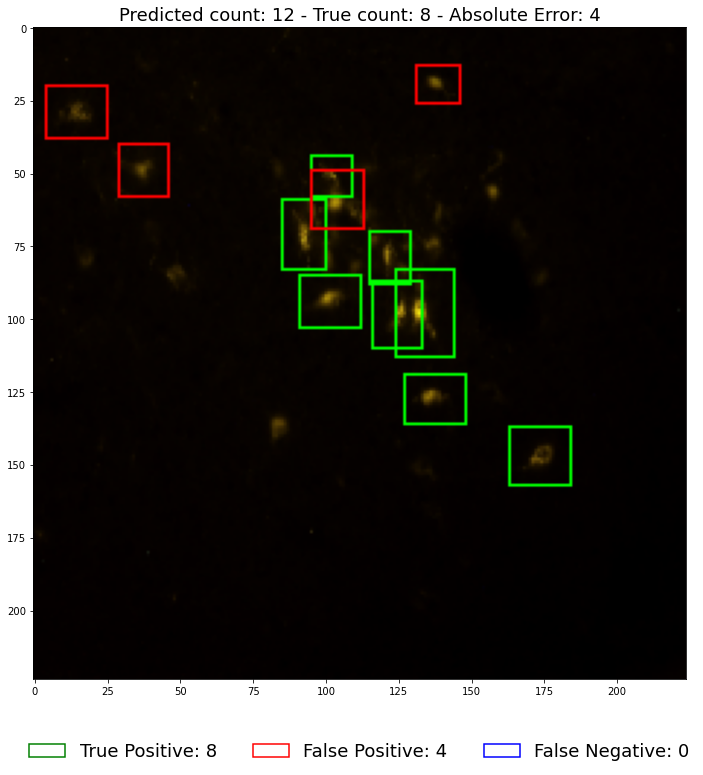

Mar26bS1C2R2_VLPAGl_200x_y.png


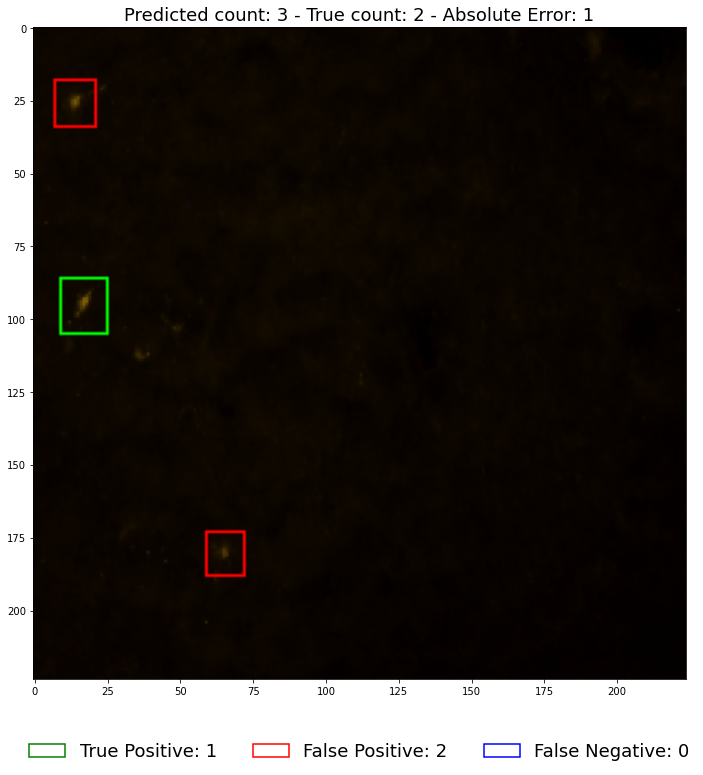

Mar27bS1C2R3_LHr_200x_y.png


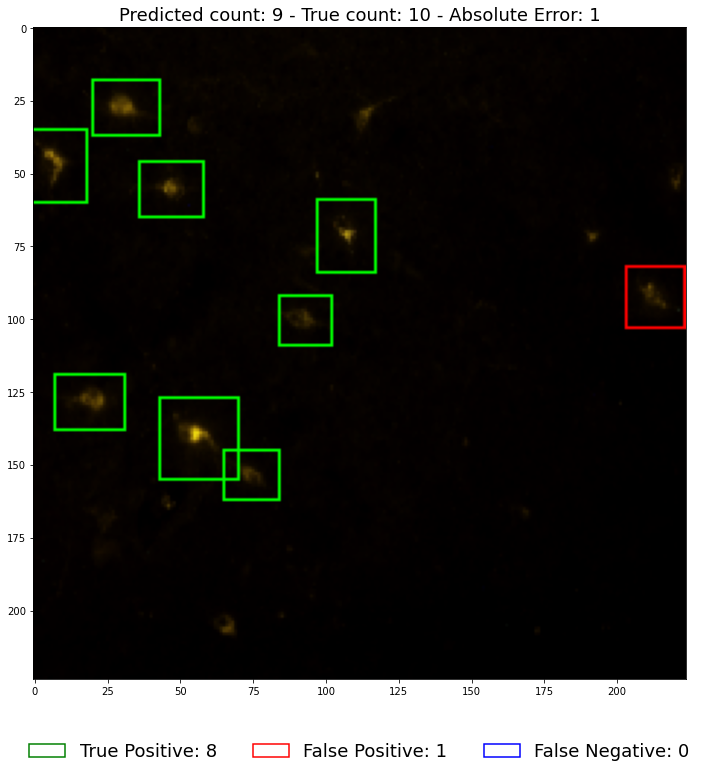

Mar19bS2C1R1_LHr_200x_y.png


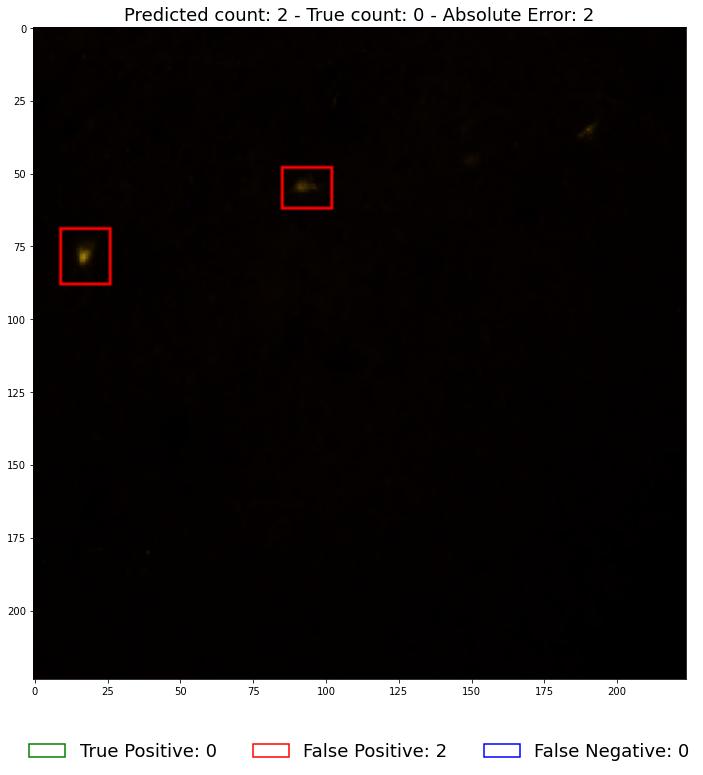

Mar19bS1C3R2_VLPAGr_200x_y.png


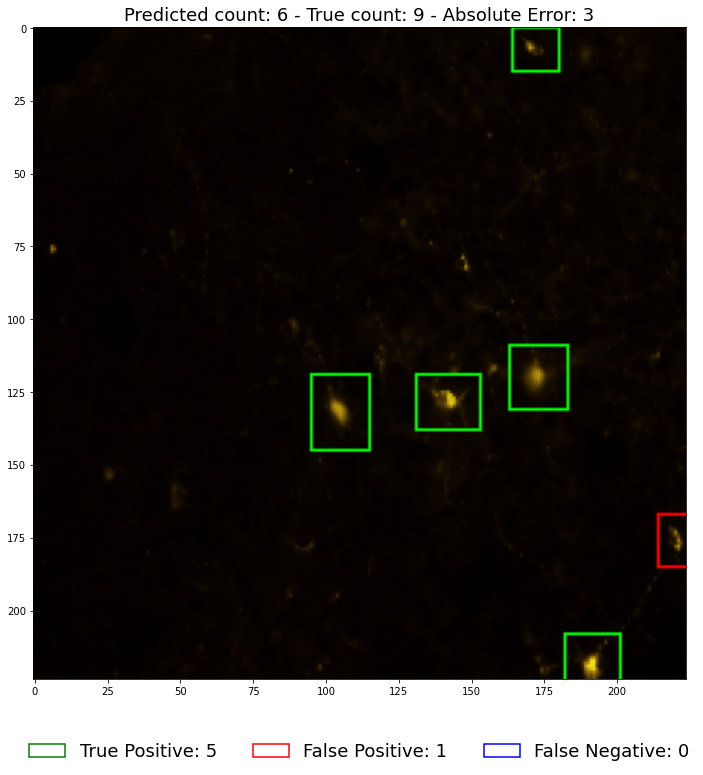

Mar20bS2C3R2_LHl_200x_y.png


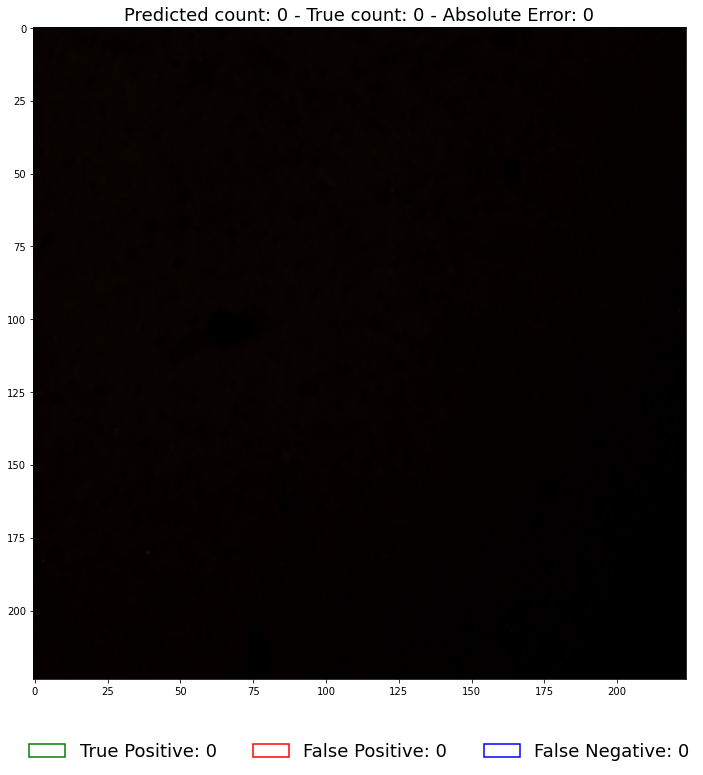

Mar21bS1C4R2_LHr_200x_y.png


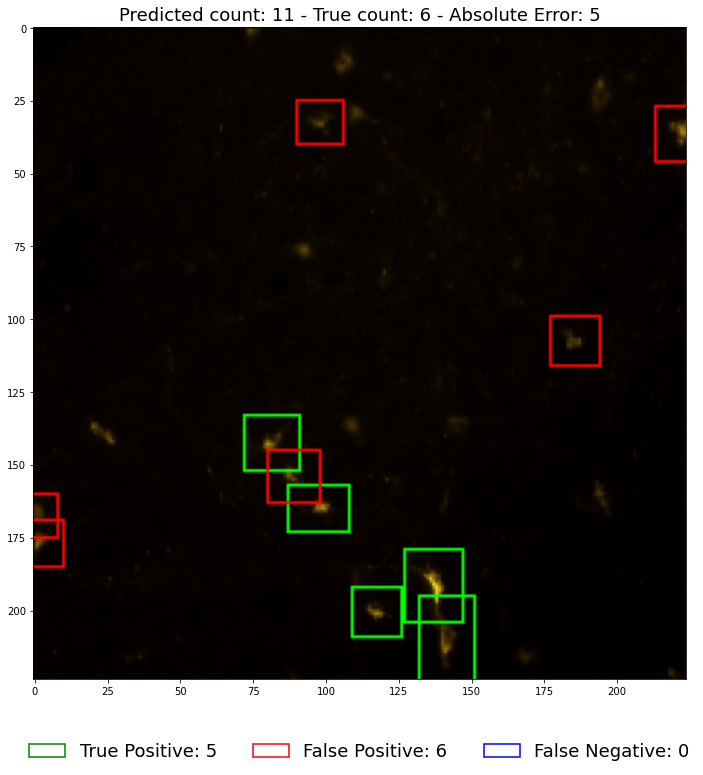

Mar26bS2C1R1_DMr_200x_y.png


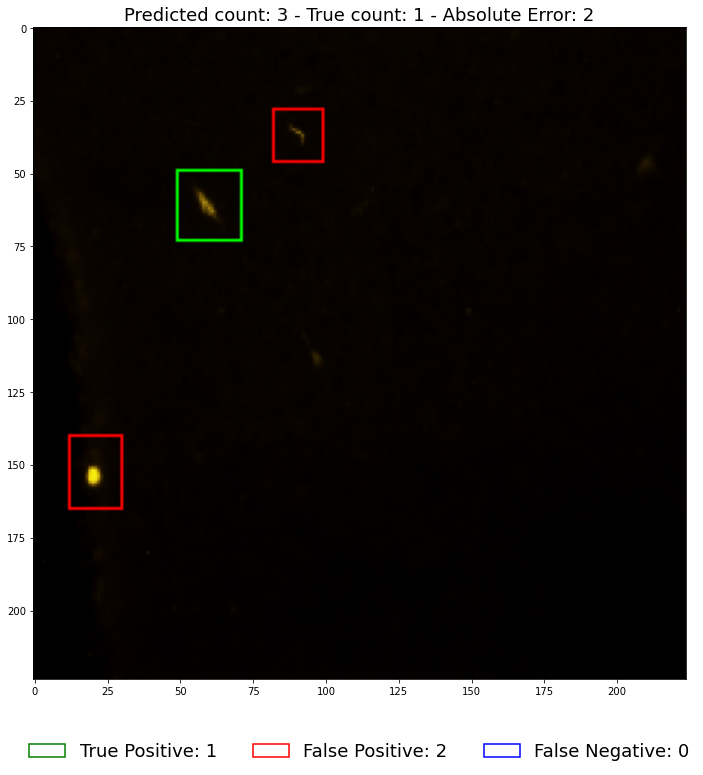

39_y.png


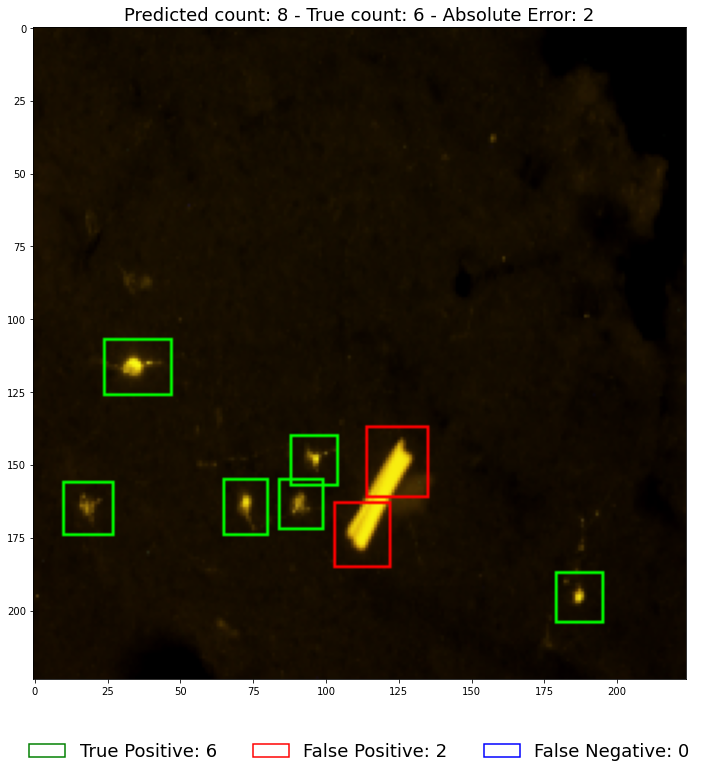

Mar21bS1C2R3_VLPAGr_200x_y.png


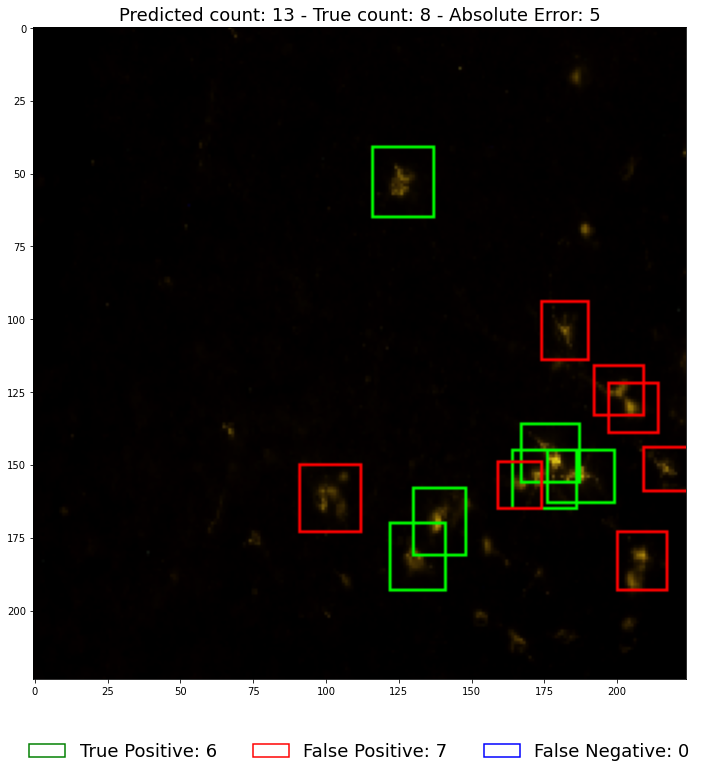

Mar23bS2C1R1_LHr_200x_y.png


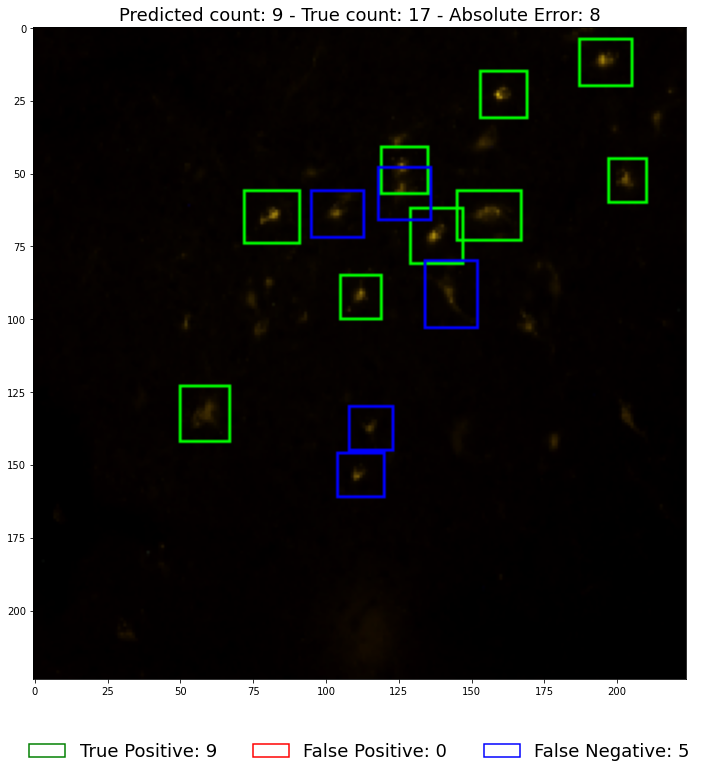

Mar37S1C2R1_DMl_200x_o.png


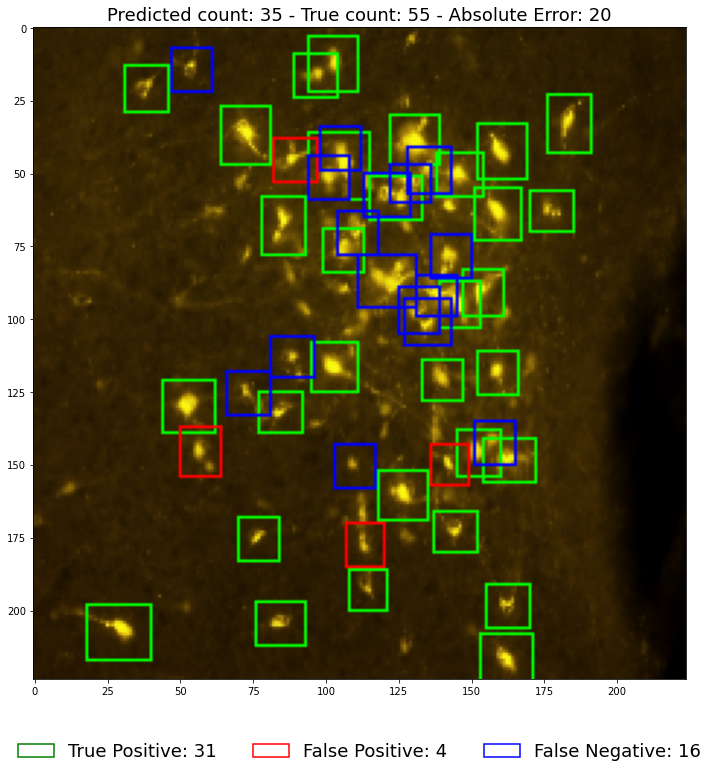

Mar19bS2C2R1_LHr_200x_y.png


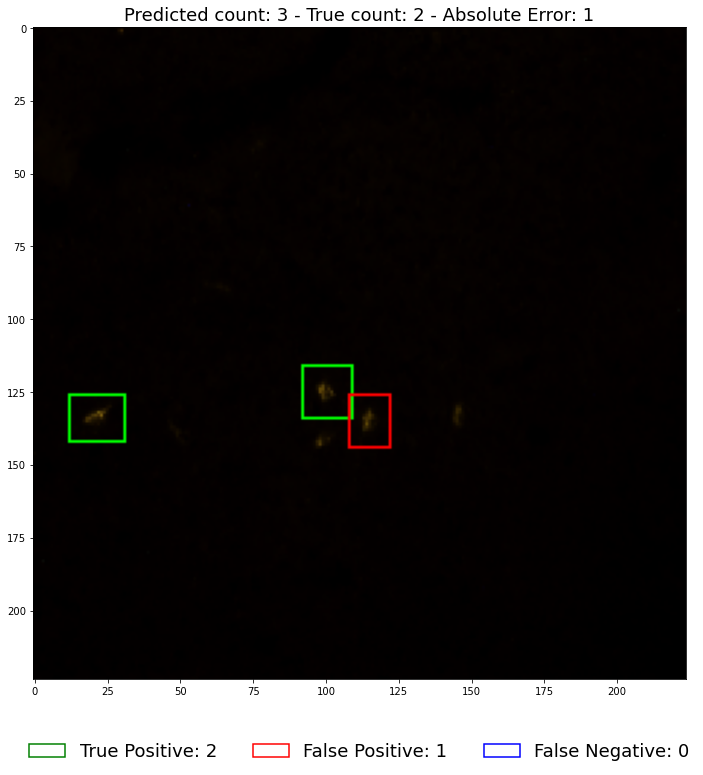

Mar22bS1C2R1_VLPAGl_200x_y.png


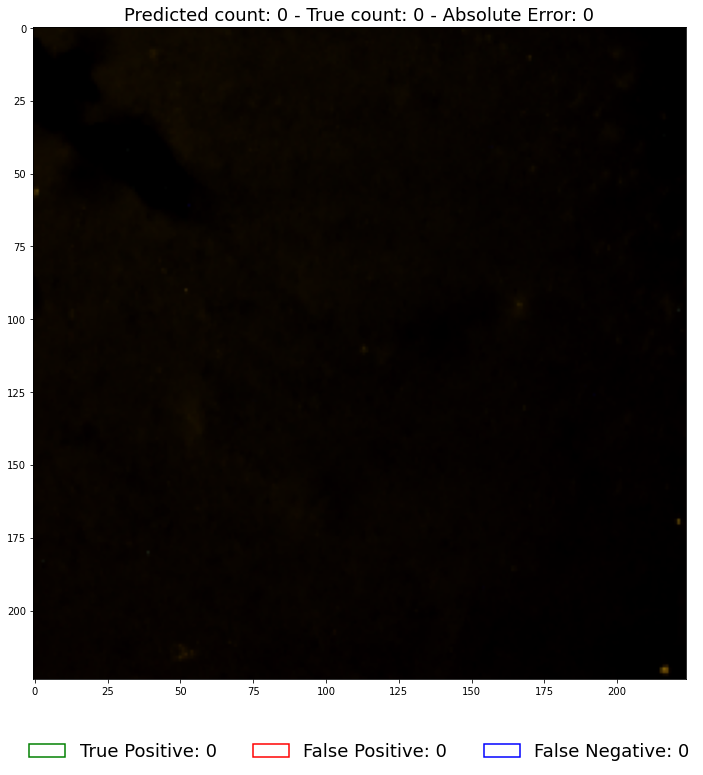

Mar23bS1C2R3_VLPAGl_200x_y.png


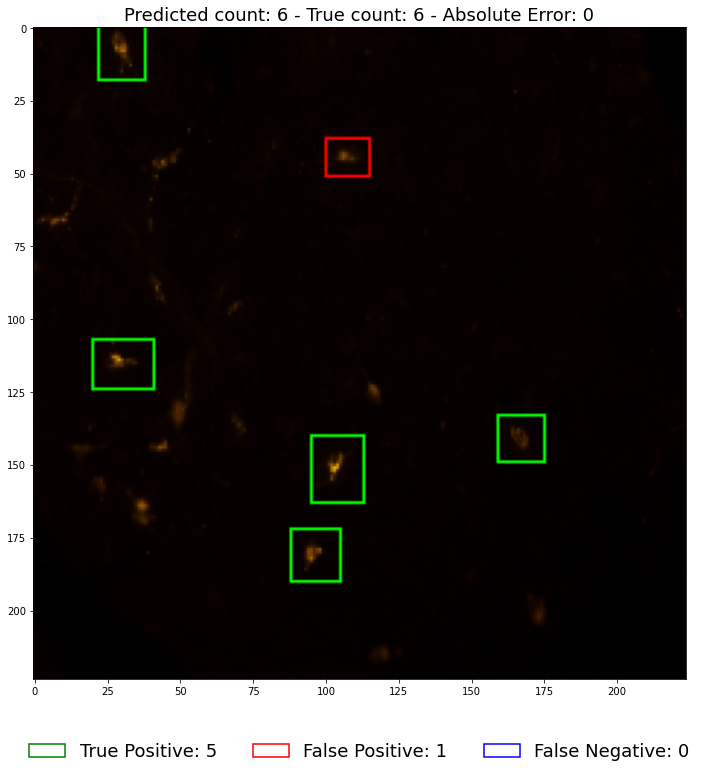

Mar20bS2C2R1_LHr_200x_y.png


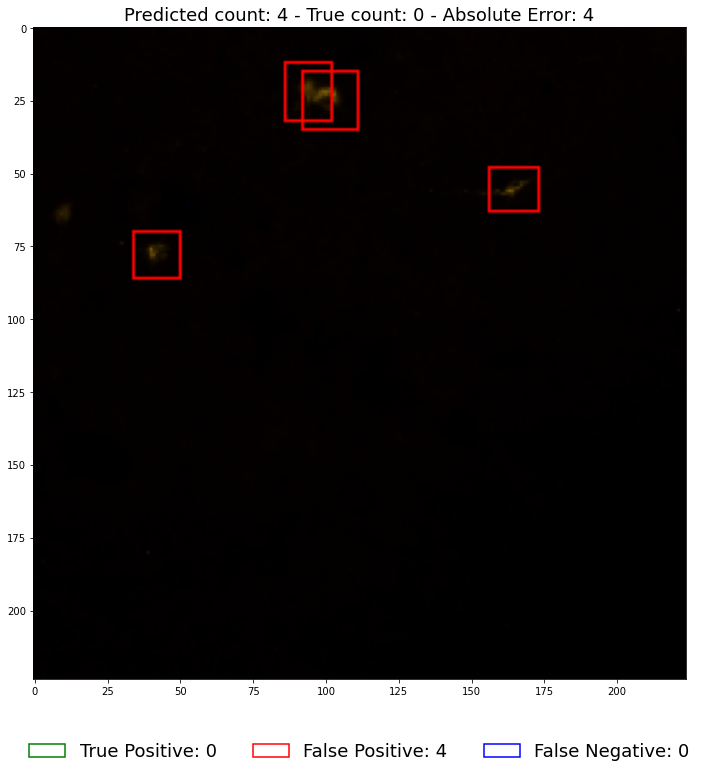

Mar26bS2C2R2_DMr_200x_y.png


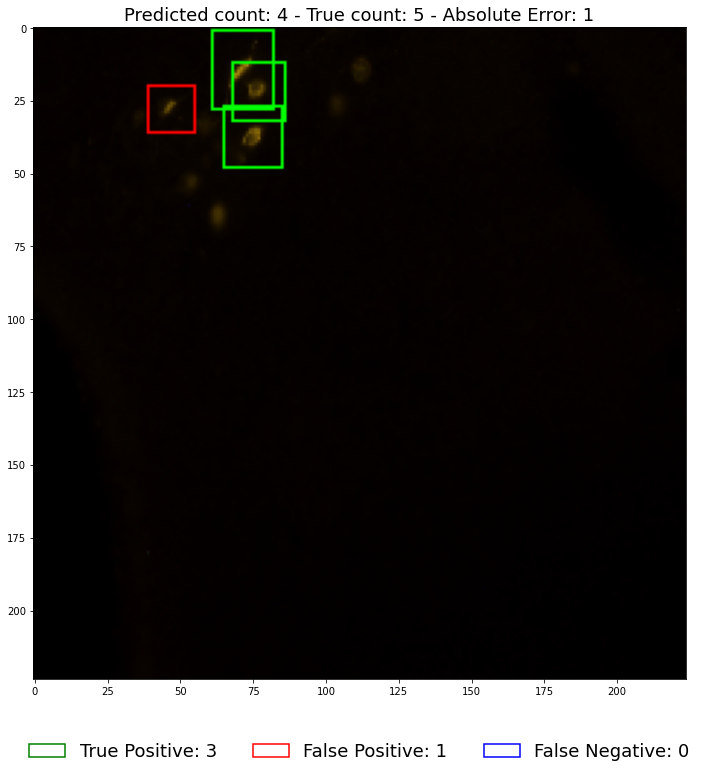

Mar21bS1C2R2_VLPAGr_200x_y.png


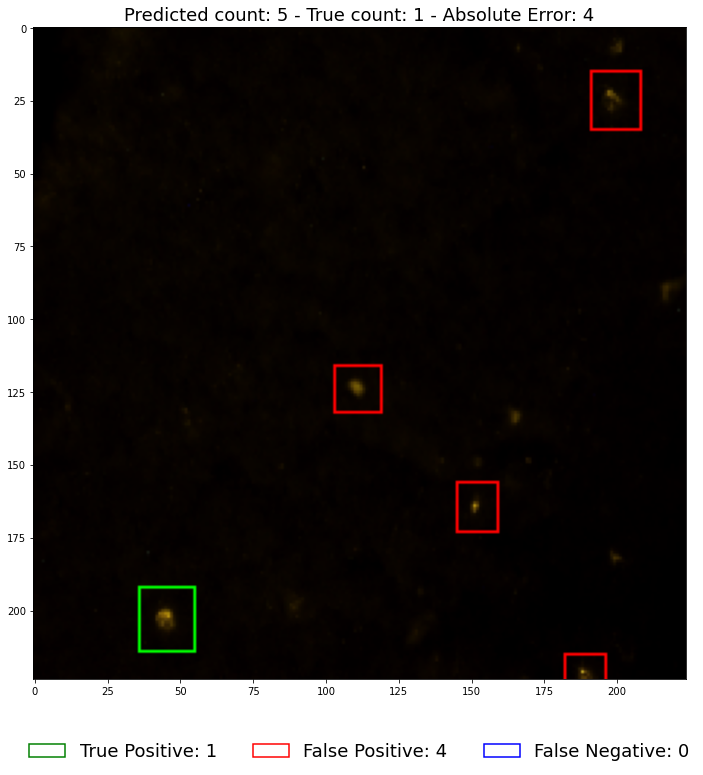

Mar21bS1C2R1_VLPAGr_200x_y.png


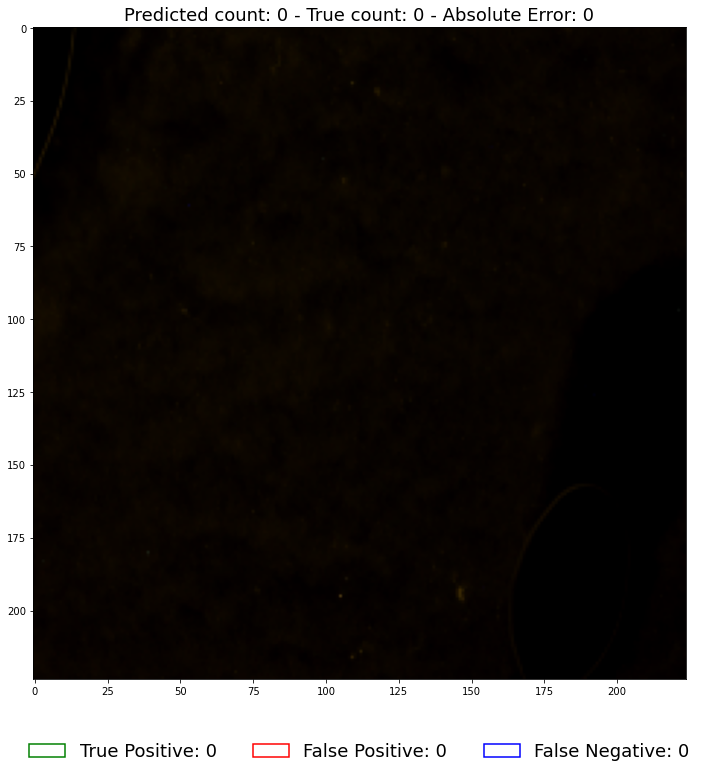

Mar24bS2C2R2_VLPAGl_200x_y.png


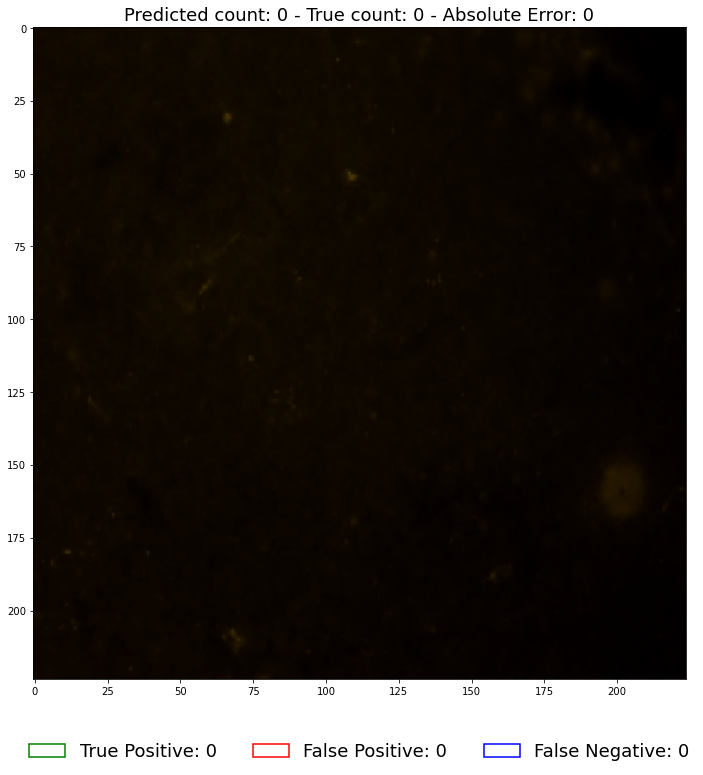

Mar19bS1C3R3_VLPAGl_200x_y.png


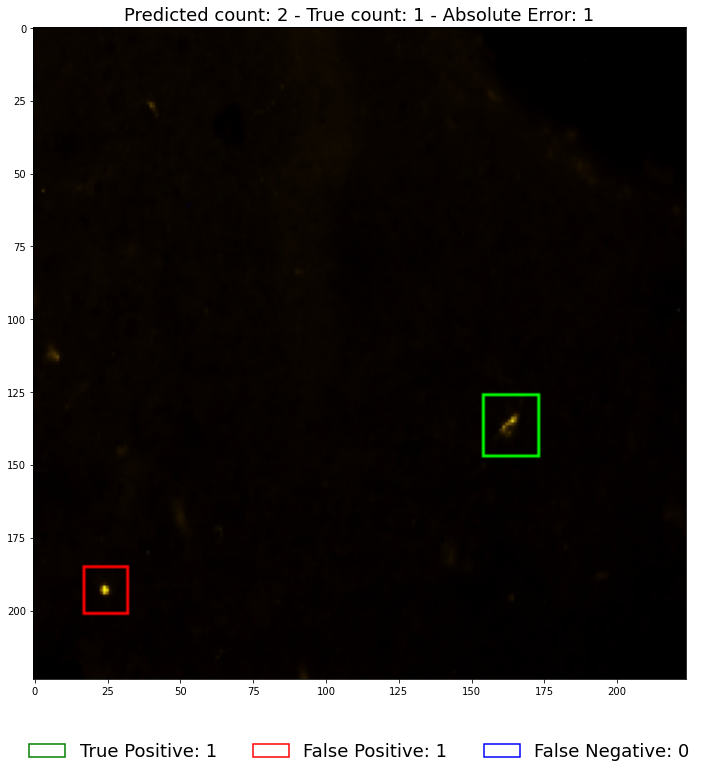

Mar26bS2C2R1_DMl_200x_y.png


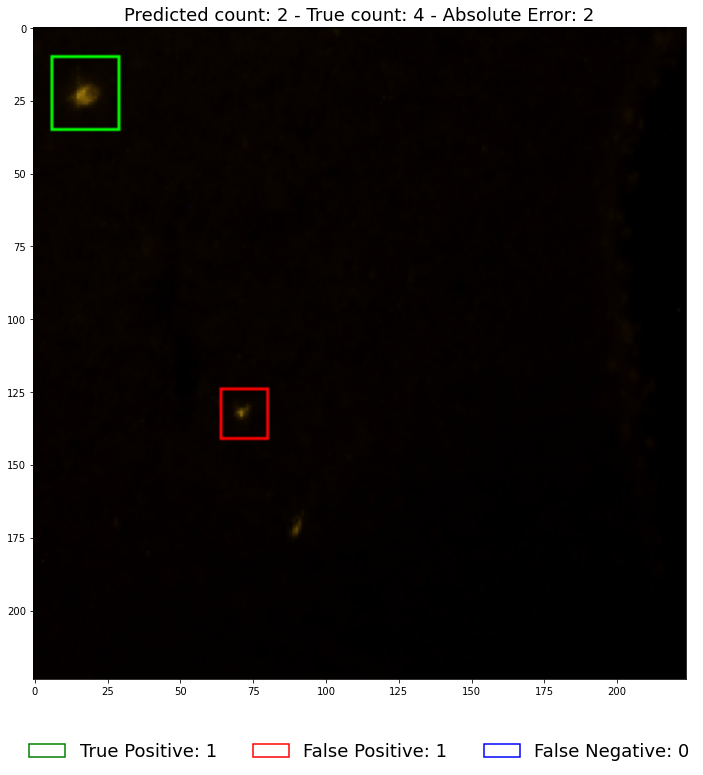

Mar24bS2C4R3_LHl_200x_y.png


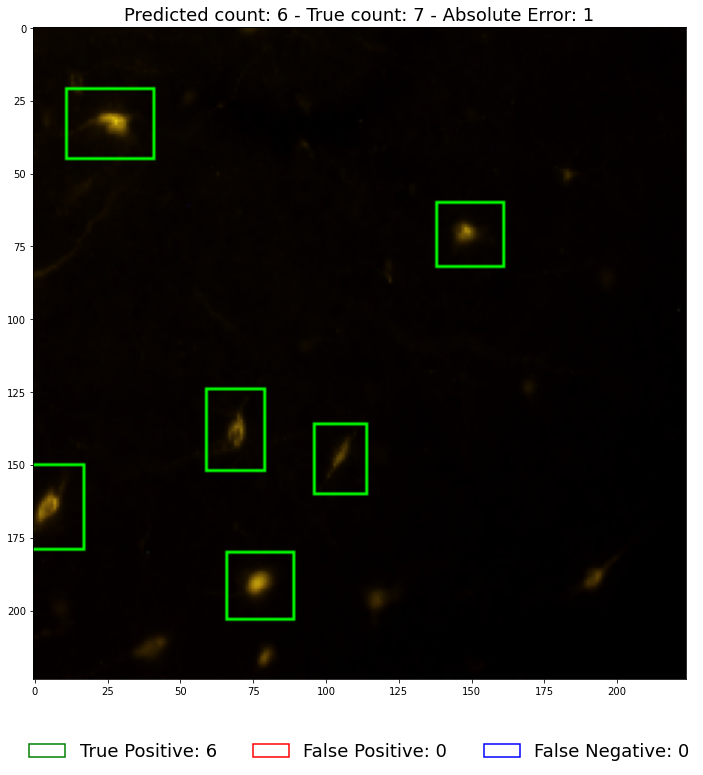

In [11]:
for idx, b in tqdm(enumerate(test_dl), total=test_dl.n):
    img_name = test_dl.items[idx]

    img, mask = b
    with torch.no_grad():
        heatmap = learn.model(img)

    pred_mask = thresh_format(heatmap, t).squeeze().permute(
        1, 2, 0).argmax(dim=2).squeeze().type(torch.uint8)
    pred_mask = mask_post_processing(pred_mask)

    # convert image for plotting
    img = img.squeeze().permute(1, 2, 0)
    img = np.ascontiguousarray(img*255, dtype=np.uint8)

    # visualize metrics
    plot_predictions_with_metrics(img, img_name.name,
                                  pred_mask, mask.squeeze(), None)

Dall'ispezione visiva sembra emergere una tendenza a **overprediction**, cioè il modello tende a predire più oggetti di quelli realmente annotati, creando così **falsi positivi**.
Allo stesso tempo, nella maggior parte dei casi si tratta di macchie effettivamente simili a quelle delle cellule che però non sono state marcate perchè più sfumate/tenui.
Questo rispecchia la soggettività intrinseca del riconoscimento in alcuni casi limite, per cui è questi errori sono in parte inevitabili in quanto anche operatori esperti diversi (o lo stesso operatore in momenti diversi) potrebbero giungere a conclusioni diverse per questi esempi.

Allo stesso tempo, utilizzare un approccio automatico garantirebbe l'introduzione di un effetto sistematico per il riconoscimento dei casi limite, rendendo quindi più comparabili i risultati ottenuti da esperimenti diversi.

  0%|          | 0/28 [00:00<?, ?it/s]

Mar37S1C2R1_DMl_200x_o.png


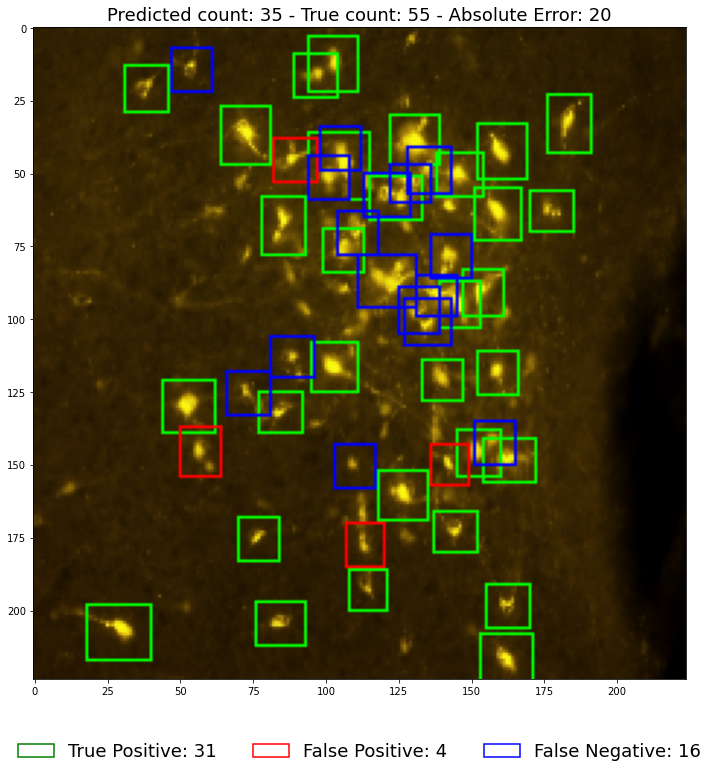

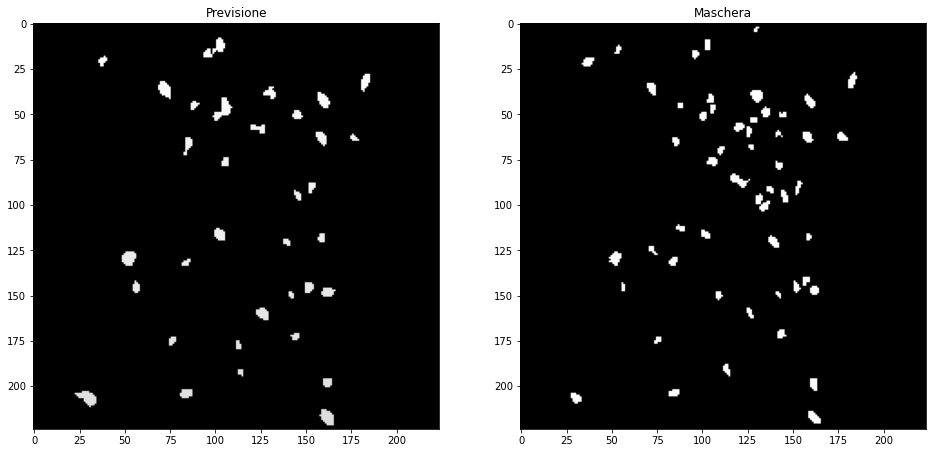

In [12]:
for idx, b in tqdm(enumerate(test_dl), total=test_dl.n):
    img_name = test_dl.items[idx]
    
    if 'Mar37S1C2R1_DMl_200x_o' not in img_name.name: continue
        
    img, mask = b
    with torch.no_grad():
        heatmap = learn.model(img)

    pred_mask = thresh_format(heatmap, t).squeeze().permute(1,2,0).argmax(dim=2).squeeze().type(torch.uint8) # .to('cpu')
    pred_mask = mask_post_processing(pred_mask)

    # convert image for plotting
    img = img.squeeze().permute(1, 2, 0)
    img = np.ascontiguousarray(img*255, dtype=np.uint8)

    # visualize metrics
    plot_predictions_with_metrics(img, img_name.name,
                                  pred_mask, mask.squeeze(), None)
    
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].imshow(pred_mask, cmap='gray')
    ax[0].set_title('Previsione')
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title('Maschera')
    

Riguardo ai falsi negativi invece, l'ispezione visiva rivela come siano concentrati in una sola immagine.
In particolare, il modello sembra far fatica a riconoscere oggetti di dimensioni modeste in immagini con poco contrasto rispetto allo sfondo.
Si potrebbe quindi pensare di usare trasformazioni di questo genere durante l'augmentation per cercare di forzare l'apprendimento di queste variazioni.

### Counting

In [13]:
from utils import plot_MAE, plot_MPE

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


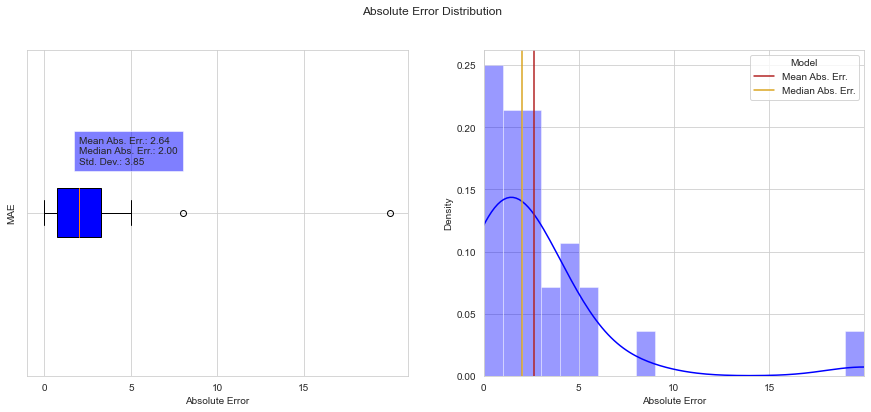

In [14]:
plot_MAE(metrics_df)

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


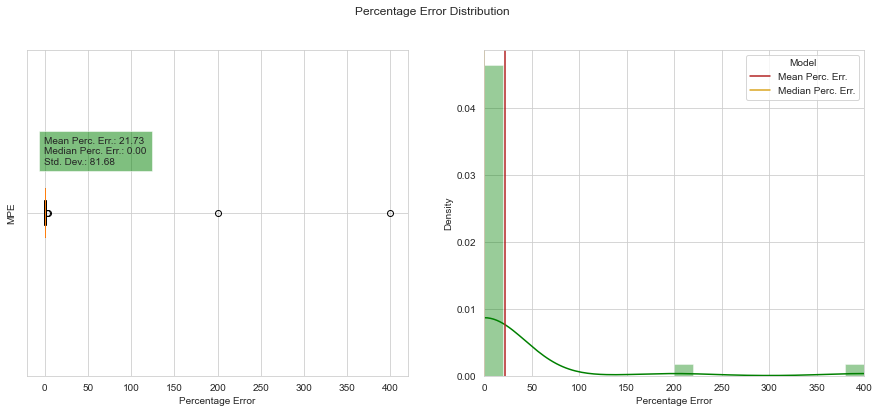

In [15]:
plot_MPE(metrics_df)

In termini di counting, le prestazioni del modello sono molto buone.

Lo **scarto assoluto** tra i conteggi predetti e quelli veri è mediamente **attorno a 2**, e la distribuzione è fortemente asimmetrica a sinistra, i.e. concentrata su valori di errore basso (< 5).

In termini percentuali, tuttavia, l'errore sembra invece più evidente. In pratica, lo scostamento si attesta vicino al 20% dei conteggi reali, con il segno positivo a suggerire che il modello tende a sovrastimare.
Tuttavia si noti che questa media è fortemente influenzata da alcuni outlier causati dall'effetto della costante  di correzione in immagini vuote. Guardando al valore mediano, al contrario, l'errore percentuale è molto più contenuto e vicino allo 0%.